In [1]:
from fbprophet import Prophet
import fbprophet.diagnostics as Prophet_Diagnostics

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from datetime import datetime
import warnings
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import locale
warnings.filterwarnings('ignore')

from GridSearchProphet import GridSearch

# locale.setlocale(locale.LC_NUMERIC, "deu_deu")

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.formatter.use_locale'] = True

# Reading data

In [2]:
# reading data
evo_data = pd.read_csv('data/demand_datasets/evo_demand.csv', index_col=0)
modo_data = pd.read_csv('data/demand_datasets/modo_demand.csv', index_col=0)
c2g_data = pd.read_csv('data/demand_datasets/c2g_demand.csv', index_col=0)

In [3]:
#cleaning process
evo_data.index = pd.to_datetime(evo_data.index)
modo_data.index = pd.to_datetime(modo_data.index)
c2g_data.index = pd.to_datetime(c2g_data.index)

Selecting the period that has less missing data between the three services.

In [4]:
init_period = '06-23'
end_period = '07-12'

evo_data = evo_data[(evo_data.index >= '2018-'+init_period) & (evo_data.index <= '2018-'+end_period)]
modo_data = modo_data[(modo_data.index >= '2018-'+init_period) & (modo_data.index <= '2018-'+end_period)]
c2g_data = c2g_data[(c2g_data.index >= '2017-'+init_period) & (c2g_data.index <= '2017-'+end_period)]

Formating the data to the Prophet dataframe structure, where the timestamps stay in the ds collumn and the values in the y column.

In [5]:
def to_prophet_data(data):
    """
        Convert a time series list to the prophet data structure
    """
    prophet_data = pd.DataFrame(list(zip(data.index, data.travels)), columns=['ds','y'])
    prophet_data.sort_values(by='ds',inplace=True)
    prophet_data.reset_index(inplace=True, drop=True)
    
    return prophet_data

In [6]:
#prophet data structure

evo_prophet = to_prophet_data(evo_data)
modo_prophet = to_prophet_data(modo_data)
c2g_prophet = to_prophet_data(c2g_data)

In [8]:
evo_prophet.head()

,ds,y
0,2018-06-23 21:00:00,1
1,2018-06-24 10:00:00,1
2,2018-06-24 15:00:00,1
3,2018-06-24 19:00:00,1
4,2018-06-25 20:00:00,1


## Train data used

In [9]:
def plot_time_points(data):
    fig, ax = plt.subplots(1,1)
    
    ax.scatter(data.ds, data.y, alpha=0.3)

    ax.set_xlim(data.ds.min(), data.ds.max())
    plt.xticks(rotation=45)
    
    plt.show()

### EVO

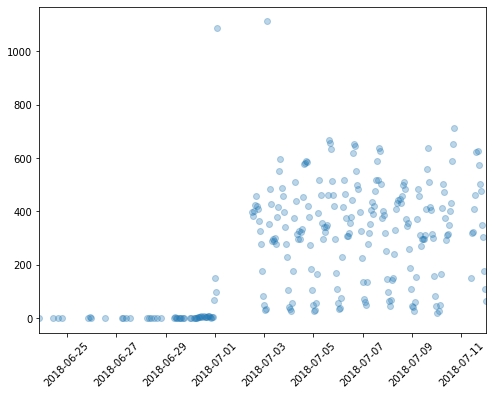

In [10]:
plot_time_points(evo_prophet)

### Modo

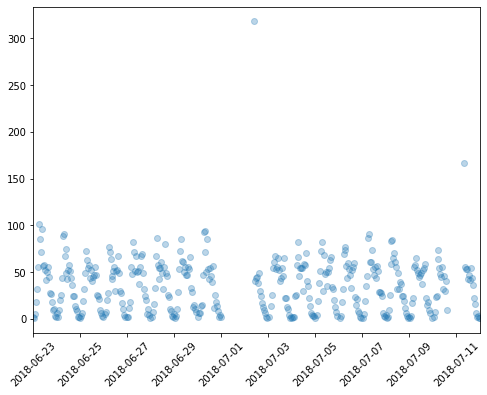

In [11]:
plot_time_points(modo_prophet)

### Car2Go

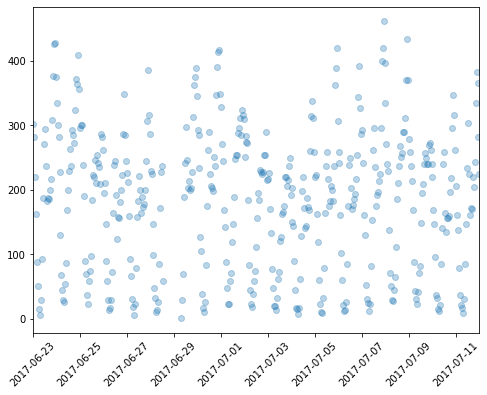

In [12]:
plot_time_points(c2g_prophet)

## Normalizing Datasets

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


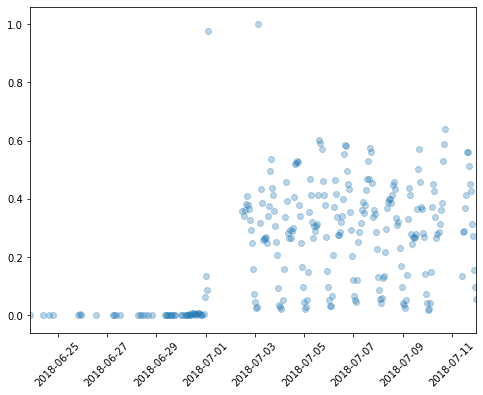

In [13]:
evo_filtered_prophet = evo_prophet
v_min = evo_filtered_prophet.y.min()
v_max = evo_filtered_prophet.y.max()
evo_filtered_prophet.y -= v_min
evo_filtered_prophet.y /= (v_max - v_min)
plot_time_points(evo_filtered_prophet)

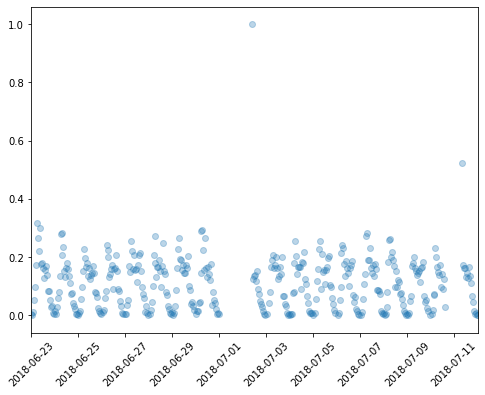

In [14]:
modo_filtered_prophet = modo_prophet
v_min = modo_filtered_prophet.y.min()
v_max = modo_filtered_prophet.y.max()
modo_filtered_prophet.y -= v_min
modo_filtered_prophet.y /= (v_max - v_min)
plot_time_points(modo_filtered_prophet)

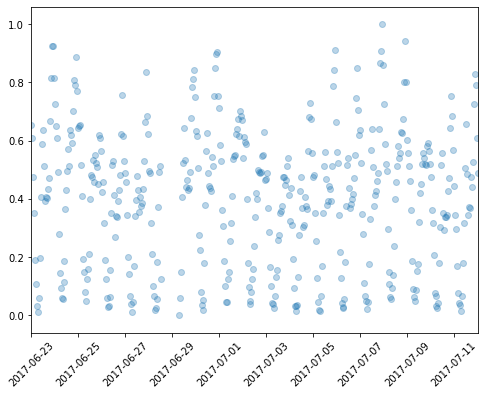

In [15]:
c2g_filtered_prophet = c2g_prophet
v_min = c2g_filtered_prophet.y.min()
v_max = c2g_filtered_prophet.y.max()
c2g_filtered_prophet.y -= v_min
c2g_filtered_prophet.y /= (v_max - v_min)
plot_time_points(c2g_filtered_prophet)

## Prophet forecast

During the selected periods there is a occurence of the Canada Day, so him will be included as parameters to the models.

In [16]:
holidays = pd.DataFrame({
  'holiday': 'Canada_day',
  'ds': pd.to_datetime(['2017-07-01','2018-07-02']),
  'lower_window': 0,
  'upper_window': 1,
})

In [20]:
# splitting in train (80%) and test data (20%)
def split(data, perc=0.8):
    index = int(len(data)*0.8)
    return data[:index], data[index:]

evo_train, evo_test = split(evo_prophet)
evo_norm_train, evo_norm_test = split(evo_filtered_prophet)

modo_train, modo_test = split(modo_prophet)
modo_norm_train, modo_norm_test = split(modo_filtered_prophet)

c2g_train, c2g_test = split(c2g_prophet)
c2g_norm_train, c2g_norm_test = split(c2g_filtered_prophet)

## Fine Tunning the models

Perform a Grid Search with a set of parameters to each service data.
The validation data will be selected from the last 20% of the train set.

In [19]:
# Possible parameters combinations
params = {
    'growth': ['linear'],
    'weekly_seasonality': [True], 
    'yearly_seasonality': [False], 
    'daily_seasonality': [True],
    'changepoint_range': [0.65, 0.7, 0.75, 0.8],
    'n_changepoints': [25, 35, 45, 50, 55],
    'changepoint_prior_scale': [0.006, 0.007, 0.008, 0.01, 0.015, 0.03, 0.05],
    'seasonality_mode': ['multiplicative'],
    'seasonality_prior_scale': [5, 15, 20, 25, 30, 35],
    'holidays': [holidays]
}

In [22]:
evo_grid_search = GridSearch(estimator=Prophet, params=params, scoring='mae', cv=1)
modo_grid_search = GridSearch(estimator=Prophet, params=params, scoring='mae', cv=1)
c2g_grid_search = GridSearch(estimator=Prophet, params=params, scoring='mae', cv=1)

In [23]:
evo_grid_search.fit(evo_norm_train)
modo_grid_search.fit(modo_norm_train)
c2g_grid_search.fit(c2g_norm_train)

100%|████████████████████████████████████████████████████████████████████████████████| 840/840 [35:58<00:00,  2.57s/it]


Services best parameters finded.

In [24]:
print(evo_grid_search.best_params_)
print(modo_grid_search.best_params_)
print(c2g_grid_search.best_params_)

{'growth': 'linear', 'weekly_seasonality': True, 'yearly_seasonality': False, 'changepoint_range': 0.7, 'n_changepoints': 50, 'changepoint_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'holidays':       holiday         ds  lower_window  upper_window
0  Canada_day 2017-07-01             0             1
1  Canada_day 2018-07-02             0             1}
{'growth': 'linear', 'weekly_seasonality': True, 'yearly_seasonality': False, 'changepoint_range': 0.7, 'n_changepoints': 55, 'changepoint_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20, 'holidays':       holiday         ds  lower_window  upper_window
0  Canada_day 2017-07-01             0             1
1  Canada_day 2018-07-02             0             1}
{'growth': 'linear', 'weekly_seasonality': True, 'yearly_seasonality': False, 'changepoint_range': 0.75, 'n_changepoints': 55, 'changepoint_prior_scale': 0.03, 'seasonality_mode': 'multiplicative', 

Best scores of each model.

In [25]:
print(evo_grid_search.best_score_)
print(modo_grid_search.best_score_)
print(c2g_grid_search.best_score_)

0.12418279811755897
0.07001666738910854
0.07548968160468553


## Testing the models

Defining helper functions to create the model, plot the predictions, plot the learning curve of the models and eval the error metrics.

In [21]:
def prophet_predict(data, params, freq='min', periods=5):
    """
    Creates and fit the Prophet model give the data and parameters.
    """
    model = Prophet(**params)
    model.fit(data)
    
    future = model.make_future_dataframe(freq=freq, periods=periods)
    
    forecast = model.predict(future)
    
    return model, forecast

In [22]:
def plot_forecast(df, df_forecast, predict_period, savefile='', legend_font_size="medium",
                                    axis_value_size="medium", axis_label_size="medium"):
    """
    Plot the data with the fitted curve and predict a future period of data based on the same last period of the given data.
    """

    plt.figure(figsize=(30,10))
    plt.scatter(df.ds,df.y,c='black',s=8,label='Real Values')
    plt.plot(df_forecast.ds[:-predict_period], df_forecast.yhat[:-60*12], label='Predicted Values')
    plt.fill_between(df_forecast.ds,df_forecast.yhat_upper,df_forecast.yhat_lower,
                     label='Uncertainty Interval',alpha=0.3)
    plt.plot(df_forecast.ds[-predict_period:], df_forecast.yhat[-60*12:], label='Future Predicted Values',ls='--')

    plt.xlim(df_forecast.ds.min(), df_forecast.ds.max())
    plt.ylabel('Travels', fontdict={"fontsize":axis_label_size})
    plt.xlabel('Hour', fontdict={"fontsize":axis_label_size})
    plt.legend(fontsize=legend_font_size, loc=1, borderaxespad=0.2, frameon=False)
    plt.tick_params(axis="both", labelsize=axis_value_size)
    plt.xticks(rotation=45)
    
    ax = plt.gca()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    if savefile != '':
        plt.savefig(savefile, bbox_inches='tight')

    plt.show()

In [23]:
def learning_curve(data, params, test=None, split=0.8, cv=5):
    """
    Plot the learning curve of the model given the parameters and the data.
    """
    
    train_error = []
    val_error = []
    test_error = []
    step_size = int(len(data)/cv)
    
    steps = range(step_size, len(data)+step_size, step_size)
    
    for step in steps:
        dataset = data[:step]
        
        split_size = int(len(dataset) * split)
        train, val = dataset[:split_size], dataset[split_size:]
        
        model = Prophet(**params)
        model.fit(train)
        train_predictions = model.predict(train[['ds']])
        predictions = model.predict(val[['ds']])
        
        if test is not None: 
            test_predictions = model.predict(test[['ds']])
            test_error.append(mean_absolute_error(test.y, test_predictions.yhat))
        
        train_error.append(mean_absolute_error(train.y, train_predictions.yhat))
        val_error.append(mean_absolute_error(val.y, predictions.yhat))
    
    plt.plot(steps, train_error, label='train')
    plt.plot(steps, val_error, label='validation')
    if test is not None:
        plt.plot(steps, test_error, label='test')
    
    plt.title('Learning Curve')
    plt.xlabel('Dataset size')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

In [7]:
def eval_model(y, y_hat):
    """
    Return the error metrics obtained by the prediction of the y_hat.
    """
    
    evaluation = {}
    evaluation["rmse"] = np.sqrt(mean_squared_error(y, y_hat))
    evaluation["mse"] = mean_squared_error(y, y_hat)
    evaluation["mae"] = mean_absolute_error(y, y_hat)
    evaluation["r2"] = r2_score(y, y_hat)

    return evaluation

In [17]:
plot_styling = {
    "legend_font_size":32,
    "axis_value_size":32,
    "axis_label_size":34
}

In [24]:
# Parameters finded with the Grid Search
evo_params = {
    'growth': 'linear', 'weekly_seasonality': True, 'daily_seasonality': True,
    'yearly_seasonality': False, 'changepoint_range': 0.7, 'n_changepoints': 50,
    'changepoint_prior_scale': 0.007, 'seasonality_mode': 'multiplicative',
    'seasonality_prior_scale': 25, 'holidays': holidays
}
modo_params = {
    'growth': 'linear', 'weekly_seasonality': True, 'daily_seasonality': True, 
    'yearly_seasonality': False, 'changepoint_range': 0.7, 'n_changepoints': 55,
    'changepoint_prior_scale': 0.007, 'seasonality_mode': 'multiplicative',
    'seasonality_prior_scale': 20, 'holidays': holidays
}
c2g_params = {
    'growth': 'linear', 'weekly_seasonality': True, 'daily_seasonality': True,
    'yearly_seasonality': False, 'changepoint_range': 0.75, 'n_changepoints': 55,
    'changepoint_prior_scale': 0.03, 'seasonality_mode': 'multiplicative',
    'seasonality_prior_scale': 5, 'holidays': holidays
}

Fitting the models with the best parameters and the train data.

In [25]:
# Period to be predicted by the models
PREDICT_PERIOD = 60*12  # 12 hours

evo_model, evo_forecast = prophet_predict(evo_norm_train, periods=PREDICT_PERIOD, params=evo_params)
print('EVO done.')
modo_model, modo_forecast = prophet_predict(modo_norm_train, periods=PREDICT_PERIOD, params=modo_params)
print('Modo done.')
c2g_model, c2g_forecast = prophet_predict(c2g_norm_train, periods=PREDICT_PERIOD, params=c2g_params)
print('Car2Go done.')

EVO done.
Modo done.
Car2Go done.


### EVO

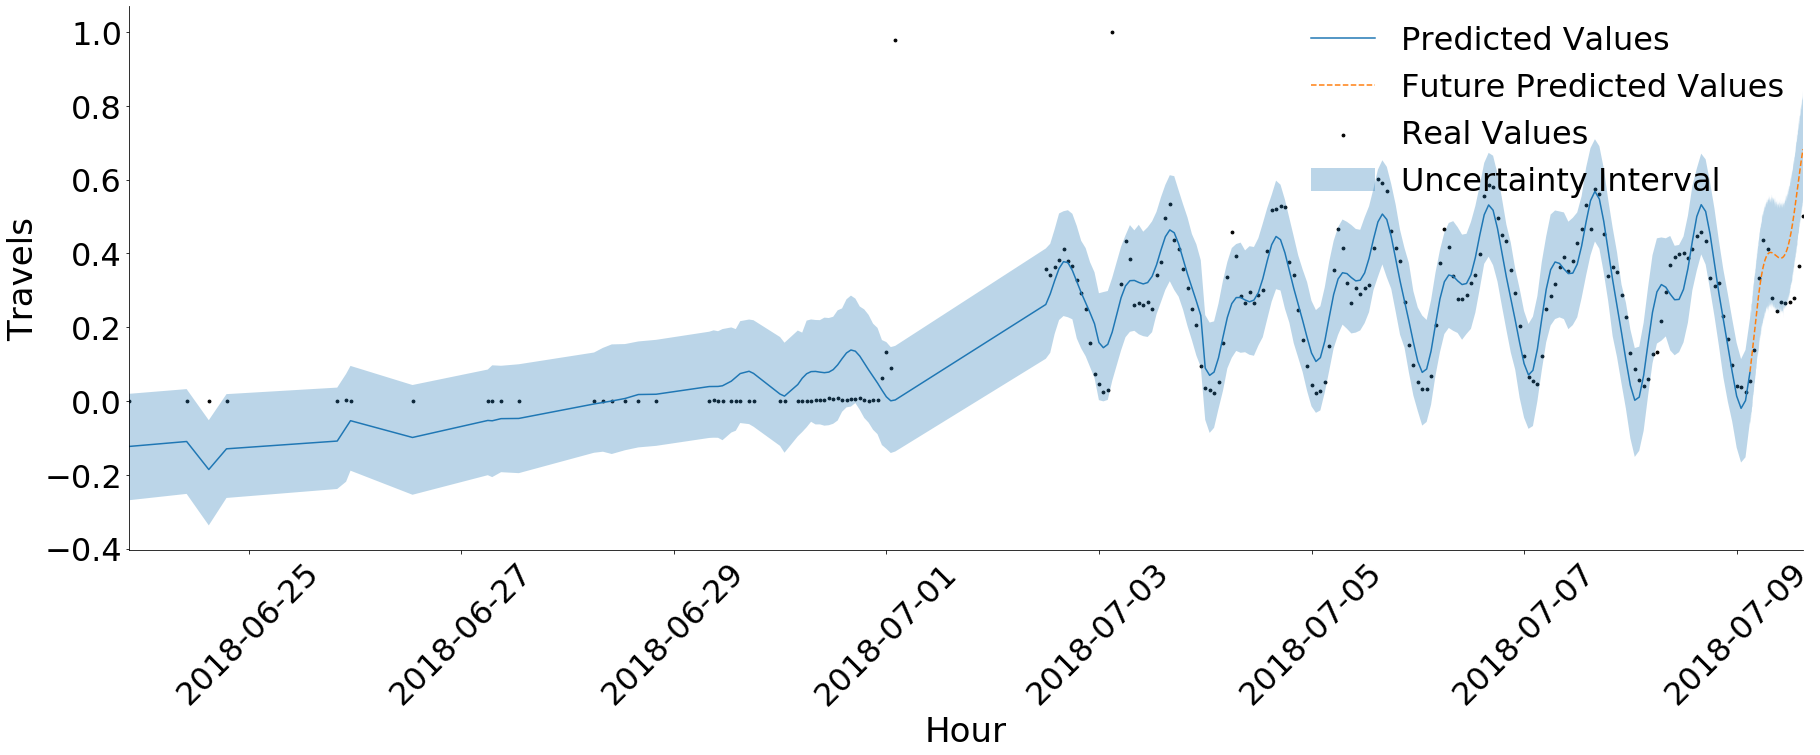

In [42]:
plot_forecast(evo_filtered_prophet, evo_forecast, PREDICT_PERIOD, savefile='images/prophet/evo.png', **plot_styling)

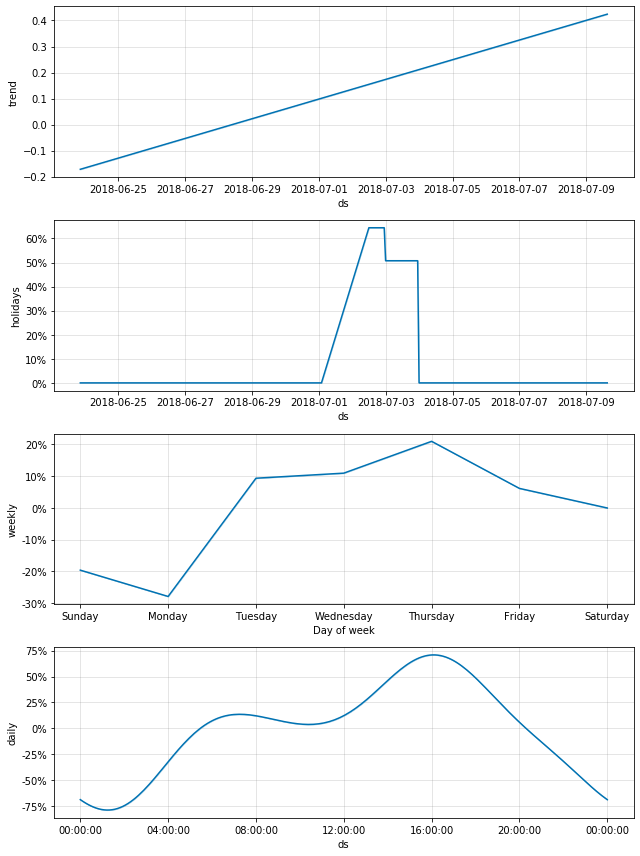

In [27]:
fig1 = evo_model.plot_components(evo_forecast)
plt.show()

#### Learning Curve

INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 14.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 29.
INFO:fbprophet:n_changepoints greater than number of observations.Using 38.
INFO:fbprophet:n_changepoints greater than number of observations.Using 45.


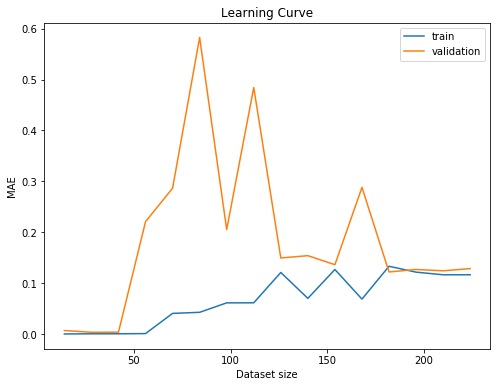

In [28]:
learning_curve(evo_norm_train, evo_params, cv=15)

#### Metrics

In [29]:
prediction = evo_model.predict(evo_norm_test[['ds']])
print(eval_model(evo_norm_test.y, prediction.yhat))

{'rmse': 0.24547520454460287, 'mse': 0.060258076046214616, 'mae': 0.2239345263714793, 'r2': -1.464184388040672}


### Modo

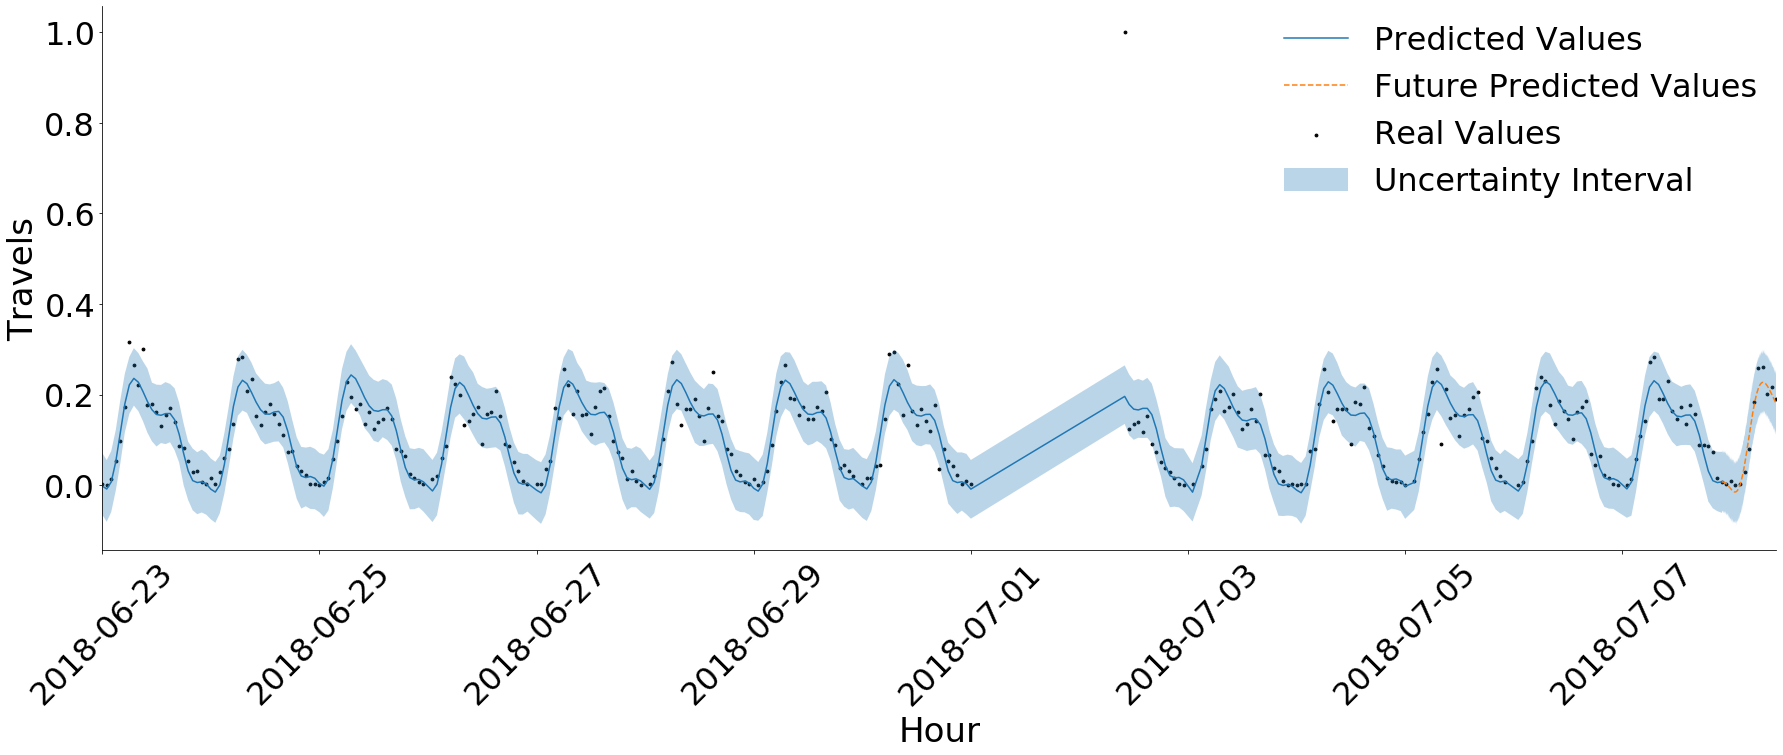

In [39]:
plot_forecast(modo_filtered_prophet, modo_forecast, PREDICT_PERIOD, 'images/prophet/modo.png', **plot_styling)

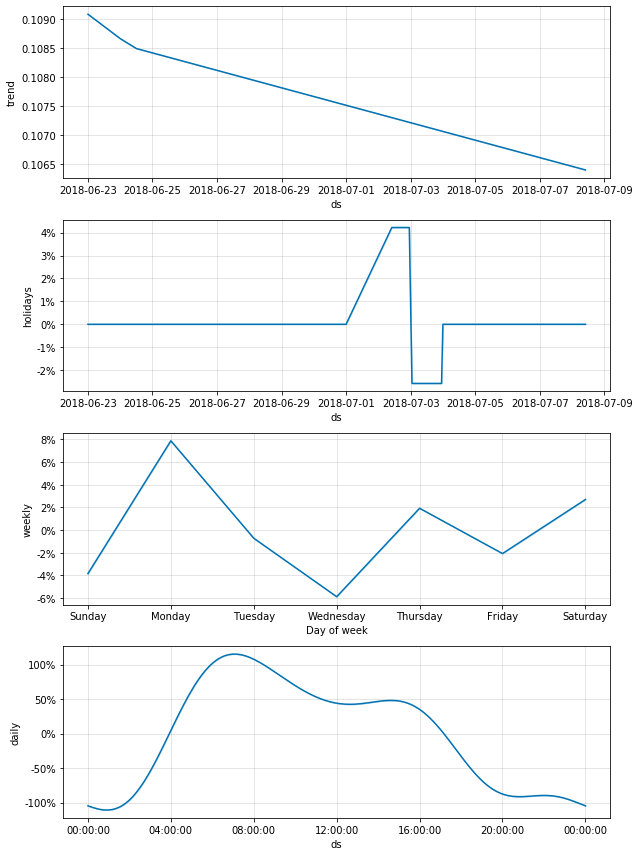

In [31]:
fig1 = modo_model.plot_components(modo_forecast)
plt.show()

#### Learning Curve

INFO:fbprophet:n_changepoints greater than number of observations.Using 10.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 34.
INFO:fbprophet:n_changepoints greater than number of observations.Using 45.


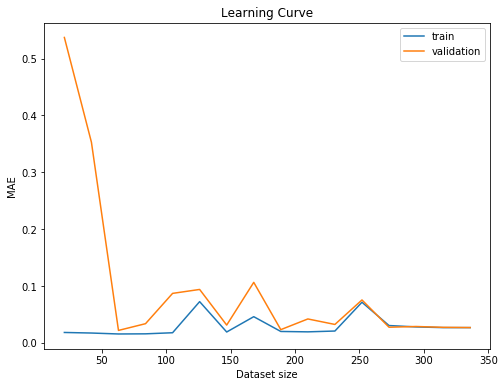

In [32]:
learning_curve(modo_norm_train, modo_params, cv=15)

In [33]:
prediction = modo_model.predict(modo_norm_test[['ds']])
print(eval_model(modo_norm_test.y, prediction.yhat))

{'rmse': 0.04708353554642155, 'mse': 0.0022168593195511415, 'mae': 0.027256567745697395, 'r2': 0.7047497872303314}


### Car2Go

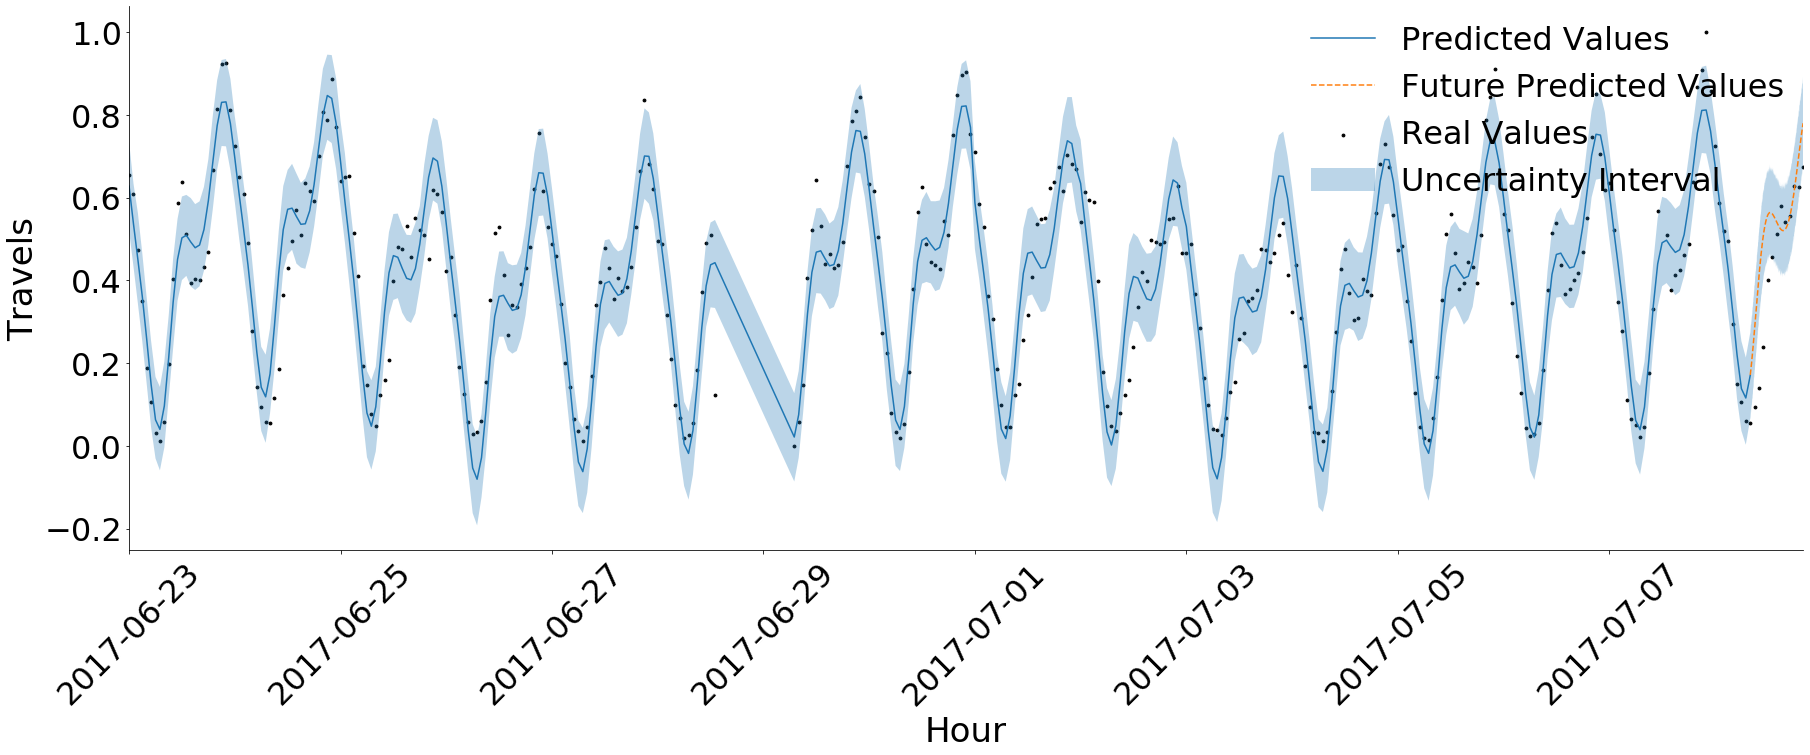

In [41]:
plot_forecast(c2g_filtered_prophet,c2g_forecast,PREDICT_PERIOD, 'images/prophet/c2g.png', **plot_styling)

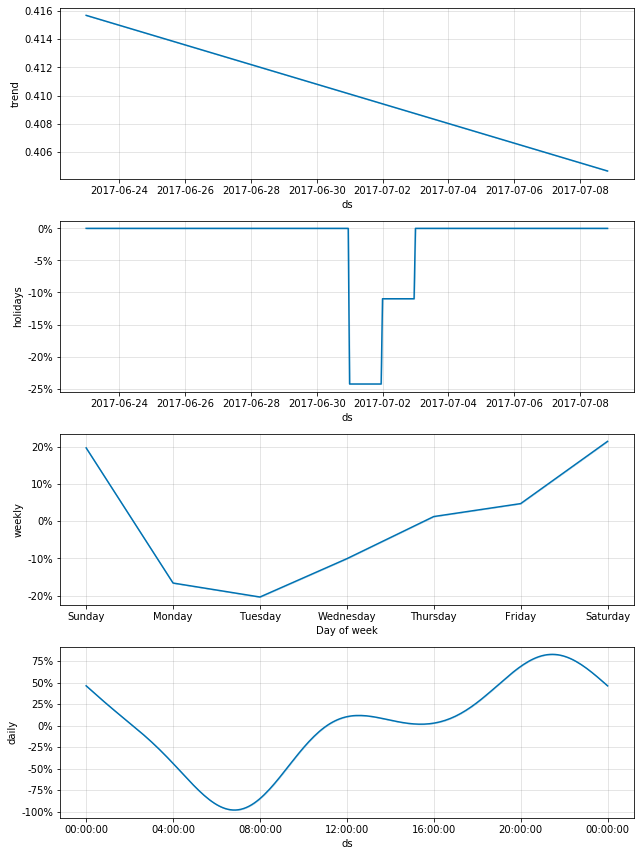

In [35]:
fig1 = c2g_model.plot_components(c2g_forecast)
plt.show()

#### Learning Curve

INFO:fbprophet:n_changepoints greater than number of observations.Using 12.
INFO:fbprophet:n_changepoints greater than number of observations.Using 26.
INFO:fbprophet:n_changepoints greater than number of observations.Using 40.
INFO:fbprophet:n_changepoints greater than number of observations.Using 53.


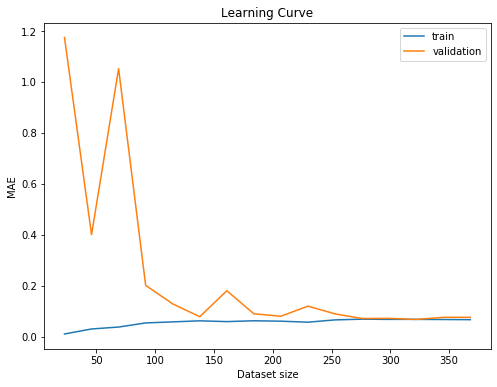

In [36]:
learning_curve(c2g_norm_train, c2g_params, cv=15)

In [37]:
prediction = c2g_model.predict(c2g_norm_test[['ds']])
print(eval_model(c2g_norm_test.y, prediction.yhat))

{'rmse': 0.09901988625956012, 'mse': 0.009804937874856224, 'mae': 0.07630233882073169, 'r2': 0.8039362763081174}
